# Script 22-censo_pop_voronoi elaboration

This notebook was used to create Script 22, and make changes to functions 
* aup.calculate_censo_nan_values_v1
* aup.voronoi_points_within_aoi
* aup.socio_points_to_polygon

All together, the script and functions creates tables *__pobcenso-inegi-{year}-mzaageb-node__* and *__pobcenso-inegi-{year}-mzaageb-hex__* on *__censo__* schema.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Function run Aguascalientes test (step by step)

In [2]:
# Not used
# censo_column_start = 14 #column where numeric data starts in censo (16 for 2010, 14 for 2020)
# censo_column_end = 0 #column where numeric data ends in censo (-1 for 2010, all up to the end (0) for 2020)

### 1. LOAD DATA

In [3]:
city = 'Aguascalientes'
year = '2020'
res_list = [8,9]

metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
query = f"SELECT * FROM {metro_schema}.{metro_table}"
metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
metro_gdf = metro_gdf.set_crs("EPSG:4326")

In [4]:
##########################################################################################
# STEP 1: LOAD DATA

# --------------- 1.1 CREATE AREA OF INTEREST FOR CITY
city_gdf = metro_gdf.loc[metro_gdf.city == city]
city_gdf = city_gdf.set_crs("EPSG:4326")
aoi = city_gdf.dissolve()

# --------------- 1.2 LOAD POP DATA
print("Loading AGEBs for area of interest.")
pop_ageb_gdf = aup.gdf_from_polygon(aoi,'censoageb',f'censoageb_{year}')
pop_ageb_gdf = pop_ageb_gdf.set_crs("EPSG:4326")

print("Loading blocks for area of interest.")
pop_mza_gdf = aup.gdf_from_polygon(aoi,'censo_mza',f'censo_mza_{year}')
pop_mza_gdf = pop_mza_gdf.set_crs("EPSG:4326")
if year == '2020':
    pop_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Urbana'].copy()

Loading AGEBs for area of interest.
Loading blocks for area of interest.


### 2. CALCULATE NaN VALUES

In [5]:
##########################################################################################
# STEP 2: CALCULATE NaN VALUES for pop fields (most of them) of gdf containing blocks.

print("--"*30)
print("STARTING nan calculating function for block's pop fields.")

# --------------- 2.1 CALCULATE_CENSO_NAN_VALUES Function
pop_mza_gdf_calc = aup.calculate_censo_nan_values_v1(pop_ageb_gdf,pop_mza_gdf,extended_logs=False)

------------------------------------------------------------
STARTING nan calculating function for block's pop fields.
STARTING NANs calculation.
Calculating NaNs. 10% done.
Calculating NaNs. 20% done.
Calculating NaNs. 30% done.
Calculating NaNs. 40% done.
Calculating NaNs. 50% done.
Calculating NaNs. 60% done.
Calculating NaNs. 70% done.
Calculating NaNs. 80% done.
Calculating NaNs. 90% done.
Calculating NaNs. 100% done.
Finished calculating NaNs.
Percentage of NaNs found using blocks gdf: 79.7%.
Columns which could be solved entirely using equations in block_gdf: 4980.0.
Columns which required AGEB filling: 9916.0.


In [6]:
print(pop_mza_gdf_calc.shape)
print(pop_mza_gdf_calc.pobtot.sum())
pop_mza_gdf_calc.loc[pop_mza_gdf_calc.pobtot.isna()]

(12932, 239)
1041064


,cvegeo,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,ambito,tipomza,geometry,entidad,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic


### 3. DISTRIBUTE POP BLOCK DATA TO NODES USING VORONOI

In [7]:
##########################################################################################
# STEP 3: DISTRIBUTE POP BLOCK DATA TO NODES USING VORONOI

print("--"*30)
print("DISTRIBUTING POP DATA FROM BLOCKS TO NODES.")

# --------------- 3.0 LOAD NODES
print("Loading nodes for area of interest.")

if year == '2010':
    _, nodes, _ = aup.graph_from_hippo(aoi, schema='networks', edges_folder='edges_2011', nodes_folder='nodes_2011')
    # FOR VIALIDADES 2011 ONLY: Drop unncessary columns from nodes column (only present in 2010)
    nodes.drop(['ID', 'TIPOVIA', 'TIPO', 
                'NUMERO', 'DERE_TRAN', 'ADMINISTRA', 'NUME_CARR', 'CONDICION', 
                'ORIGEN', 'CALI_REPR', 'CVEGEO', 'NOMVIAL', 'SENTIDO', 'LONGITUD', 'UNIDAD', 
                'vertex_pos', 'vertex_ind', 'vertex_par', 'vertex_p_1', 
                'distance', 'angle'], inplace = True, axis=1)
    
elif year == '2020':
    _, nodes, _ = aup.graph_from_hippo(aoi, schema='osmnx', edges_folder='edges_23_line', nodes_folder='nodes_23_point')

nodes.reset_index(inplace=True)
nodes = nodes.to_crs("EPSG:4326")

# --------------- 3.1 CREATE VORONOI POLYGONS USING NODES

print("Creating voronois with nodes osmid data.")

# Create voronois
voronois_gdf = aup.voronoi_points_within_aoi(aoi,nodes,'osmid')
nodes_voronoi_gdf = voronois_gdf[['osmid','geometry']]

# --------------- 3.2 SPATIAL INTERSECTION OF POLYGONS WITH BLOCKS

print("Creating spatial join between voronoi polygons and blocks.")

# Calculate block area
mza_gdf = pop_mza_gdf_calc.to_crs("EPSG:6372")
mza_gdf['area_mza'] = mza_gdf.geometry.area
mza_gdf = mza_gdf.to_crs("EPSG:4326")

# Overlay blocks with voronoi (Spatial intersection)
mza_voronoi = gpd.overlay(df1=mza_gdf, df2=nodes_voronoi_gdf, how="intersection")
del mza_gdf

print("Calculating area_pct that corresponds to each osmid within each block.")

# Calculate pct of area that corresponds to each osmid within each block
mza_voronoi = mza_voronoi.to_crs("EPSG:6372")
mza_voronoi['area_voronoi'] = mza_voronoi.geometry.area
mza_voronoi = mza_voronoi.to_crs("EPSG:4326")
mza_voronoi['area_pct'] = mza_voronoi['area_voronoi']/mza_voronoi['area_mza']

# Drop used columns
mza_voronoi.drop(columns=['area_mza','area_voronoi'],inplace=True)

# --------------- 3.3 SUM POB DATA THAT CORRESPONDS TO EACH NODE (Groups mza_voronoi data by osmid)

print("Adding pob data by node.")

columns_of_interest = ['POBTOT','POBFEM','POBMAS',
                'P_0A2','P_0A2_F','P_0A2_M',
                'P_3A5','P_3A5_F','P_3A5_M',
                'P_6A11','P_6A11_F','P_6A11_M',
                'P_12A14','P_12A14_F','P_12A14_M',
                'P_15A17','P_15A17_F','P_15A17_M',
                'P_18A24','P_18A24_F','P_18A24_M',
                'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
                'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
                'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
                'POB0_14','POB15_64','POB65_MAS'] # Similar to columns_of_interest inside function calculate_censo_nan_values_v1 but with POBTOT and without REL_H_M.

pop_nodes_gdf = nodes.copy()
if year == '2010':
    pop_nodes_gdf.drop(columns=['x','y'],inplace=True)
elif year == '2020':
    pop_nodes_gdf.drop(columns=['x','y','street_count','city'],inplace=True)

for col in columns_of_interest:
    # Turn column to lower and numeric
    col = col.lower()
    mza_voronoi[col] = pd.to_numeric(mza_voronoi[col])

    # Calculate pop data proportionaly to pct that voronoi area is of block
    mza_voronoi[f'voronoi_{col}'] = mza_voronoi[col] * mza_voronoi['area_pct']

    # Group data by osmid
    osmid_grouped_data = mza_voronoi.groupby('osmid').agg({f'voronoi_{col}':np.sum})
    
    # Merge data to nodes_gdf
    osmid_grouped_data.reset_index(inplace=True)
    pop_nodes_gdf = pd.merge(pop_nodes_gdf, osmid_grouped_data, on='osmid')
    pop_nodes_gdf.rename(columns={f'voronoi_{col}':col},inplace=True)

------------------------------------------------------------
DISTRIBUTING POP DATA FROM BLOCKS TO NODES.
Loading nodes for area of interest.
Creating voronois with nodes osmid data.
Error = 0.49%. Repeating process.
Error = 0.23%. Repeating process.
Error = 0.0%. Admissible.
Creating spatial join between voronoi polygons and blocks.
Calculating area_pct that corresponds to each osmid within each block.
Adding pob data by node.


In [8]:
print(pop_nodes_gdf.shape)
print(pop_nodes_gdf.pobtot.sum())
pop_nodes_gdf.loc[pop_nodes_gdf.pobtot.isna()]

(35950, 41)
1041063.9769270906


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_12ymas_m,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas


In [9]:
print(list(pop_nodes_gdf.columns))
pop_nodes_gdf.head(1)

['osmid', 'geometry', 'pobtot', 'pobfem', 'pobmas', 'p_0a2', 'p_0a2_f', 'p_0a2_m', 'p_3a5', 'p_3a5_f', 'p_3a5_m', 'p_6a11', 'p_6a11_f', 'p_6a11_m', 'p_12a14', 'p_12a14_f', 'p_12a14_m', 'p_15a17', 'p_15a17_f', 'p_15a17_m', 'p_18a24', 'p_18a24_f', 'p_18a24_m', 'p_60ymas', 'p_60ymas_f', 'p_60ymas_m', 'p_3ymas', 'p_3ymas_f', 'p_3ymas_m', 'p_12ymas', 'p_12ymas_f', 'p_12ymas_m', 'p_15ymas', 'p_15ymas_f', 'p_15ymas_m', 'p_18ymas', 'p_18ymas_f', 'p_18ymas_m', 'pob0_14', 'pob15_64', 'pob65_mas']


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_12ymas_m,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas
0,272921360,POINT (-102.29507 21.87288),0.828358,0.393971,0.437472,-0.007713,0.0,-0.003085,0.001732,0.001073,...,0.43593,0.792571,0.373764,0.418807,0.744288,0.373764,0.370525,0.038873,0.683512,0.109059


In [10]:
# VISUAL TEST
#aoi.to_file('../../../data/external/temporal_fromjupyter/voronoi_censo_test/aoi_ags.gpkg', driver='GPKG')
#nodes.to_file('../../../data/external/temporal_fromjupyter/voronoi_censo_test/nodes_ags.gpkg', driver='GPKG')
#voronois_gdf.to_file('../../../data/external/temporal_fromjupyter/voronoi_censo_test/voronois_ags.gpkg', driver='GPKG')

### 4. TURN NODES POP DATA TO HEXS POP DATASET

#### 4a) Changes to function aup.socio_points_to_polygon

* __Problem:__ Points left out outside polygons.
* __Solution:__ Assigns points outside polygon to closest arista of a given polygon.

#### 4.a Llegar hasta donde se usa aup.socio_points_to_polygon en el paso 4b

In [10]:
res = 8 #Simplificar res para el test
hex_socio_gdf = gpd.GeoDataFrame()
# --------------- 4.1 LOAD HEXGRID
print(f"Loading hexgrid res {res} for area of interest.")
query = f"SELECT * FROM hexgrid.hexgrid_{res}_city_2020 WHERE \"city\" LIKE \'{city}\'"
hex_res_gdf = aup.gdf_from_query(query, geometry_col='geometry')
hex_res_gdf = hex_res_gdf.set_crs("EPSG:4326")

# Format - Remove res from index name and add column with res
hex_res_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
hex_res_gdf['res'] = res
print(f"Created hex_grid with {res} resolution")

# Group pop data (aup.socio_points_to_polygon)

Loading hexgrid res 8 for area of interest.
Created hex_grid with 8 resolution


#### 4.a Paso a paso de socio_points_to_polygon

##### New way (Aristas)

In [54]:
# def socio_points_to_polygon(gdf_polygon,gdf_socio,cve_column,string_columns,wgt_dict=None,avg_column=None):

gdf_polygon = hex_res_gdf.copy()
gdf_socio = pop_nodes_gdf.copy()
cve_column = 'hex_id'
string_columns = ['osmid']

In [55]:
dictionary_list = []
# Adds census data from points to polygon
gdf_tmp = gpd.sjoin(gdf_socio, gdf_polygon)  # joins points to polygons
gdf_tmp.head(1)

,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,pob0_14,pob15_64,pob65_mas,index_right,hex_id,CVEGEO,NOMGEO,city,type,res
0,272921360,POINT (-102.29507 21.87288),0.828358,0.393971,0.437472,-0.007713,0.0,-0.003085,0.001732,0.001073,...,0.038873,0.683512,0.109059,420,88498e3651fffff,01001,Aguascalientes,Aguascalientes,urban,8


In [56]:
# FIND POINTS LEFT OUTSIDE SJOIN
# Find how gdf_socio osmids and gdf_tmp osmids relate (through indicator) and 
gdf_socio_merge = gdf_socio.merge(gdf_tmp[['osmid']], on=['osmid'], how='left', indicator=True)
# Select points which fell outside gdf_polygon area ('left_only')
gdf_socio_outside = gdf_socio_merge.loc[gdf_socio_merge['_merge']=='left_only']
gdf_socio_outside = gdf_socio_outside.drop(columns=['_merge'])

# Show
print(gdf_socio_outside.shape)
gdf_socio_outside.head(1)

(10, 41)


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_12ymas_m,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas
19081,2168312687,POINT (-102.26917 22.07988),44.993562,21.903588,23.089974,2.979126,0.684556,2.29457,2.687044,1.362078,...,18.322203,32.796104,16.045762,16.750342,31.465146,15.361207,16.103939,12.197458,25.796037,7.000067


In [57]:
# Show
print(gdf_polygon.shape)
gdf_polygon.head(1)

(2088, 7)


,hex_id,geometry,CVEGEO,NOMGEO,city,type,res
0,88498e3289fffff,"POLYGON ((-102.16756 21.82626, -102.16297 21.8...",01001,Aguascalientes,Aguascalientes,rural,8


In [58]:
# GET GDF_POLYGON VERTICES
# Extract gdf_polygon's coords
gdf_poly_edges = gdf_polygon.copy()
gdf_poly_edges['geometry'] = gdf_poly_edges.geometry.boundary

# Show
print(gdf_poly_edges.shape)
gdf_poly_edges.head(1)

(2088, 7)


,hex_id,geometry,CVEGEO,NOMGEO,city,type,res
0,88498e3289fffff,"LINESTRING (-102.16756 21.82626, -102.16297 21...",01001,Aguascalientes,Aguascalientes,rural,8


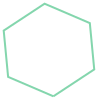

In [59]:
gdf_poly_edges.loc[0,'geometry']

In [60]:
#FIND NEAREST hex_id TO EACH OSMID
gdf1 = gdf_socio_outside.to_crs('EPSG:6372')
gdf2 = gdf_poly_edges.to_crs('EPSG:6372')

# Find nearest gdf1 to each gdf2
nearest = gpd.sjoin_nearest(gdf1, gdf2,lsuffix="left", rsuffix="right")
gdf_tmp_2 = nearest.to_crs('EPSG:4326')

# Show
print(gdf_tmp_2.shape)
gdf_tmp_2.head(1)

(10, 48)


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,pob0_14,pob15_64,pob65_mas,index_right,hex_id,CVEGEO,NOMGEO,city,type,res
19081,2168312687,POINT (-102.26917 22.07988),44.993562,21.903588,23.089974,2.979126,0.684556,2.29457,2.687044,1.362078,...,12.197458,25.796037,7.000067,1975,88498e2617fffff,01011,San Francisco de los Romo,Aguascalientes,urban,8


##### Old way (Vertices)

In [61]:
# FIND POINTS LEFT OUTSIDE PREVIOUS SJOIN
# Find how gdf_socio points_id and gdf_tmp_1 points_id relate (through indicator) and 
gdf_socio_merge = gdf_socio.merge(gdf_tmp[['osmid']], on=['osmid'], how='left', indicator=True)
# Select points which fell outside gdf_polygon area ('left_only')
gdf_socio_outside = gdf_socio_merge.loc[gdf_socio_merge['_merge']=='left_only']

# Show
print(gdf_socio_outside.shape)
gdf_socio_outside.head(1)

(10, 42)


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,_merge
19081,2168312687,POINT (-102.26917 22.07988),44.993562,21.903588,23.089974,2.979126,0.684556,2.29457,2.687044,1.362078,...,32.796104,16.045762,16.750342,31.465146,15.361207,16.103939,12.197458,25.796037,7.000067,left_only


In [62]:
# GET GDF_POLYGON VERTICES
# Extract gdf_polygon's coords
gdf_coords = gdf_polygon.geometry.get_coordinates()
# Merge back with gdf containing ID data
gdf_coords_data = pd.merge(gdf_coords,gdf_polygon,left_index=True,right_index=True)
gdf_coords_data.drop_duplicates(inplace=True)
# Drop poly geometry 
df_coords_data = gdf_coords_data.drop(columns=['geometry'])
# Set points geometry
gdf_poly_vertices = gpd.GeoDataFrame(df_coords_data, 
                         geometry=gpd.points_from_xy(df_coords_data.x, df_coords_data.y),
                         crs='EPSG:4326')
# Final format
gdf_poly_vertices = gdf_poly_vertices[[cve_column,'geometry']]

# Show
print(gdf_poly_vertices.shape)
gdf_poly_vertices.head(1)

(12528, 2)


,hex_id,geometry
0,88498e3289fffff,POINT (-102.16756 21.82626)


In [65]:
#FIND NEAREST hex_id TO EACH OSMID
gdf1 = gdf_socio_outside.to_crs('EPSG:6372')
gdf2 = gdf_poly_vertices.to_crs('EPSG:6372')
nearest = gpd.sjoin_nearest(gdf1, gdf2,lsuffix="left", rsuffix="right")
# A vertex may be shared by two or more hexs, keep first.
nearest.drop_duplicates(subset='osmid',keep='first',inplace=True)
# Drop not usefull cols and merge back hexs data
nearest.drop(columns=['_merge'],inplace=True)
nearest = nearest.to_crs('EPSG:4326')
df_polygon = gdf_polygon.drop(columns=['geometry'])
gdf_tmp_2 = pd.merge(nearest,df_polygon,on=cve_column)

# Show
print(gdf_tmp_2.shape)
gdf_tmp_2.head(1)

(10, 48)


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,pob0_14,pob15_64,pob65_mas,index_right,hex_id,CVEGEO,NOMGEO,city,type,res
0,2168312687,POINT (-102.26917 22.07988),44.993562,21.903588,23.089974,2.979126,0.684556,2.29457,2.687044,1.362078,...,12.197458,25.796037,7.000067,1975,88498e2617fffff,01011,San Francisco de los Romo,Aguascalientes,urban,8


#### 4.a Prueba de la nueva función socio_points_to_polygon

In [68]:
def socio_points_to_polygon_edited(gdf_polygon,gdf_socio,cve_column,string_columns,wgt_dict=None,avg_column=None,include_nearest=False):

    dictionary_list = []
    # Adds census data from points to polygon
    gdf_tmp_1 = gpd.sjoin(gdf_socio, gdf_polygon)  # joins points to polygons
    
    if include_nearest:
        # FIND POINTS LEFT OUTSIDE SJOIN
        # Find how gdf_socio osmids and gdf_tmp osmids relate (through indicator) and 
        gdf_socio_merge = gdf_socio.merge(gdf_tmp_1[['osmid']], on=['osmid'], how='left', indicator=True)
        # Select points which fell outside gdf_polygon area ('left_only')
        gdf_socio_outside = gdf_socio_merge.loc[gdf_socio_merge['_merge']=='left_only']
        gdf_socio_outside = gdf_socio_outside.drop(columns=['_merge'])
        
        # GET GDF_POLYGON VERTICES
        # Extract gdf_polygon's coords
        gdf_poly_edges = gdf_polygon.copy()
        gdf_poly_edges['geometry'] = gdf_poly_edges.geometry.boundary
        
        #FIND NEAREST hex_id TO EACH OSMID
        gdf1 = gdf_socio_outside.to_crs('EPSG:6372')
        gdf2 = gdf_poly_edges.to_crs('EPSG:6372')
        
        # Find nearest gdf1 to each gdf2
        nearest = gpd.sjoin_nearest(gdf1, gdf2,lsuffix="left", rsuffix="right")
        gdf_tmp_2 = nearest.to_crs('EPSG:4326')

        gdf_tmp = pd.concat([gdf_tmp_1,gdf_tmp_2])
    
    else:
        gdf_tmp = gdf_tmp_1.copy()
        
    # convert data types
    all_columns = list(gdf_socio.columns)
    numeric_columns = [x for x in all_columns if x not in string_columns]
    type_dict = {"string": string_columns, "float": numeric_columns}
    gdf_tmp = aup.convert_type(gdf_tmp, type_dict)
    
    #group sociodemographic points to polygon
    for idx in gdf_tmp[cve_column].unique():
        socio_filter = gdf_tmp.loc[gdf_tmp[cve_column]==idx].copy()
        dict_tmp = aup.group_sociodemographic_data(socio_filter, numeric_columns,avg_column=avg_column, avg_dict=wgt_dict)
        dict_tmp[cve_column] = idx
        dictionary_list.append(dict_tmp)
        
    data = pd.DataFrame.from_dict(dictionary_list)
    
    return data

In [69]:
##########################################################################################
# STEP 4: TURN NODES POP DATA TO HEXS
res_list = [8,9]

hex_socio_gdf = gpd.GeoDataFrame()

for res in res_list:
    # --------------- 4.1 LOAD HEXGRID
    print(f"Loading hexgrid res {res} for area of interest.")
    query = f"SELECT * FROM hexgrid.hexgrid_{res}_city_2020 WHERE \"city\" LIKE \'{city}\'"
    hex_res_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    hex_res_gdf = hex_res_gdf.set_crs("EPSG:4326")

    # Format - Remove res from index name and add column with res
    hex_res_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_res_gdf['res'] = res
    print(f"Created hex_grid with {res} resolution")

    # Group pop data
    string_columns = ['osmid'] # Nodes string columns are not used in aup.group_sociodemographic_data. The rest are turned into numeric and processed.
    #              socio_points_to_polygon_edited(gdf_polygon,gdf_socio,cve_column,string_columns,wgt_dict=None,avg_column=None,include_nearest=False):
    hex_socio_df = socio_points_to_polygon_edited(hex_res_gdf, pop_nodes_gdf, 'hex_id', string_columns,include_nearest=True) 
    print(f"Agregated socio data to hex with a total of {hex_socio_df['pobtot'].sum()} population for resolution {res}.")

    # Hexagons data to hex_gdf GeoDataFrame
    hex_socio_gdf_tmp = hex_res_gdf.merge(hex_socio_df, on='hex_id')
    
    # Calculate population density
    hectares = hex_socio_gdf_tmp.to_crs('EPSG:6372').area / 10000
    hex_socio_gdf_tmp['dens_pob_ha'] = hex_socio_gdf_tmp['pobtot'] / hectares 
    print(f"Calculated an average density of {hex_socio_gdf_tmp['dens_pob_ha'].mean()}")
    
    # Concatenate in hex_socio_gdf, where (if more resolutions) next resolution will also be stored.
    hex_socio_gdf = pd.concat([hex_socio_gdf,hex_socio_gdf_tmp])

# Show
print(hex_socio_gdf.shape)
hex_socio_gdf.head(1)

Loading hexgrid res 8 for area of interest.
Created hex_grid with 8 resolution
Agregated socio data to hex with a total of 1041064.0 population for resolution 8.
Calculated an average density of 38.13936709219253
Loading hexgrid res 9 for area of interest.
Created hex_grid with 9 resolution
Agregated socio data to hex with a total of 1041063.9375 population for resolution 9.
Calculated an average density of 52.01249433405812
(1938, 47)


,hex_id,geometry,CVEGEO,NOMGEO,city,type,res,pobtot,pobfem,pobmas,...,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,dens_pob_ha
0,88498e3639fffff,"POLYGON ((-102.27184 21.89588, -102.26725 21.8...",01001,Aguascalientes,Aguascalientes,urban,8,6963.374023,3558.997803,3404.375977,...,5352.204102,2759.962891,2592.240967,4911.568359,2551.991455,2359.576904,1611.170166,4845.36084,506.842896,80.614392


#### 4b) After changing function in aup

In [11]:
##########################################################################################
# STEP 4: TURN NODES POP DATA TO HEXS
hex_socio_gdf = gpd.GeoDataFrame()

for res in res_list:
    # --------------- 4.1 LOAD HEXGRID
    print(f"Loading hexgrid res {res} for area of interest.")
    query = f"SELECT * FROM hexgrid.hexgrid_{res}_city_2020 WHERE \"city\" LIKE \'{city}\'"
    hex_res_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    hex_res_gdf = hex_res_gdf.set_crs("EPSG:4326")

    # Format - Remove res from index name and add column with res
    hex_res_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_res_gdf['res'] = res
    print(f"Created hex_grid with {res} resolution")

    # Group pop data
    string_columns = ['osmid'] # Nodes string columns are not used in aup.group_sociodemographic_data. The rest are turned into numeric and processed.
    hex_socio_df = aup.socio_points_to_polygon(hex_res_gdf, pop_nodes_gdf, 'hex_id', string_columns,include_nearest=(True,'osmid')) 
    print(f"Agregated socio data to hex with a total of {hex_socio_df['pobtot'].sum()} population for resolution {res}.")

    # Hexagons data to hex_gdf GeoDataFrame
    hex_socio_gdf_tmp = hex_res_gdf.merge(hex_socio_df, on='hex_id')
    
    # Calculate population density
    hectares = hex_socio_gdf_tmp.to_crs('EPSG:6372').area / 10000
    hex_socio_gdf_tmp['dens_pob_ha'] = hex_socio_gdf_tmp['pobtot'] / hectares 
    print(f"Calculated an average density of {hex_socio_gdf_tmp['dens_pob_ha'].mean()}")
    
    # Concatenate in hex_socio_gdf, where (if more resolutions) next resolution will also be stored.
    hex_socio_gdf = pd.concat([hex_socio_gdf,hex_socio_gdf_tmp])

# Final format
pop_nodes_gdf['city'] = city
hex_socio_gdf.columns = hex_socio_gdf.columns.str.lower()

# Show
print(hex_socio_gdf.shape)
hex_socio_gdf.head(1)

Loading hexgrid res 8 for area of interest.
Created hex_grid with 8 resolution
Agregated socio data to hex with a total of 1041064.0 population for resolution 8.
Calculated an average density of 38.13936709219253
Loading hexgrid res 9 for area of interest.
Created hex_grid with 9 resolution
Agregated socio data to hex with a total of 1041063.9375 population for resolution 9.
Calculated an average density of 52.01249433405812
(1938, 47)


,hex_id,geometry,cvegeo,nomgeo,city,type,res,pobtot,pobfem,pobmas,...,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,dens_pob_ha
0,88498e3639fffff,"POLYGON ((-102.27184 21.89588, -102.26725 21.8...",01001,Aguascalientes,Aguascalientes,urban,8,6963.374023,3558.997803,3404.375977,...,5352.204102,2759.962891,2592.240967,4911.568359,2551.991455,2359.576904,1611.170166,4845.36084,506.842896,80.614392


In [12]:
print(list(hex_socio_gdf.columns))
hex_socio_gdf.head(1)

['hex_id', 'geometry', 'cvegeo', 'nomgeo', 'city', 'type', 'res', 'pobtot', 'pobfem', 'pobmas', 'p_0a2', 'p_0a2_f', 'p_0a2_m', 'p_3a5', 'p_3a5_f', 'p_3a5_m', 'p_6a11', 'p_6a11_f', 'p_6a11_m', 'p_12a14', 'p_12a14_f', 'p_12a14_m', 'p_15a17', 'p_15a17_f', 'p_15a17_m', 'p_18a24', 'p_18a24_f', 'p_18a24_m', 'p_60ymas', 'p_60ymas_f', 'p_60ymas_m', 'p_3ymas', 'p_3ymas_f', 'p_3ymas_m', 'p_12ymas', 'p_12ymas_f', 'p_12ymas_m', 'p_15ymas', 'p_15ymas_f', 'p_15ymas_m', 'p_18ymas', 'p_18ymas_f', 'p_18ymas_m', 'pob0_14', 'pob15_64', 'pob65_mas', 'dens_pob_ha']


,hex_id,geometry,cvegeo,nomgeo,city,type,res,pobtot,pobfem,pobmas,...,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,dens_pob_ha
0,88498e3639fffff,"POLYGON ((-102.27184 21.89588, -102.26725 21.8...",01001,Aguascalientes,Aguascalientes,urban,8,6963.374023,3558.997803,3404.375977,...,5352.204102,2759.962891,2592.240967,4911.568359,2551.991455,2359.576904,1611.170166,4845.36084,506.842896,80.614392


In [13]:
# VISUAL TEST
#hex_res_gdf.to_file('../../../data/external/temporal_fromjupyter/voronoi_censo_test/ags_hex8.gpkg', driver='GPKG')

#### Data test - Testing how aup.socio_points_to_polygon works vs sjoin (With pobtot)

In [22]:
# # # TEST # # #

for res in [8]:
   # --------------- 4.1 LOAD HEXGRID
    print(f"Loading hexgrid res {res} for area of interest.")
    query = f"SELECT * FROM hexgrid.hexgrid_{res}_city_2020 WHERE \"city\" LIKE \'{city}\'"
    hex_res_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    hex_res_gdf = hex_res_gdf.set_crs("EPSG:4326")

    # Format - Remove res from index name and add column with res
    hex_res_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_res_gdf['res'] = res
    print(f"Created hex_grid with {res} resolution")
    
    # --------------- 4.2 ADD HEX_ID TO EACH NODE
    gdf_tmp = gpd.sjoin(hex_res_gdf,pop_nodes_gdf)

    j = 0
    df_summary = pd.DataFrame()
    # For each hex_id
    for hex_id in gdf_tmp['hex_id'].unique():
        # Find all nodes belonging to that hex_id
        gdf_tmp_hexid = gdf_tmp.loc[gdf_tmp['hex_id'] == hex_id].copy()
        # Sum test value
        value =  gdf_tmp_hexid['pobtot'].sum()
        # Register
        df_summary.loc[j,'hex_id'] = hex_id
        df_summary.loc[j,'pobtot'] = value
        j = j+1

testing = pd.merge(hex_socio_gdf,df_summary, on='hex_id')
testing = testing[['pobtot_x','pobtot_y']]
testing['diff'] = testing['pobtot_x']-testing['pobtot_y']
print(f'Diff is: {testing["diff"].sum()}.')

Loading hexgrid res 8 for area of interest.
Created hex_grid with 8 resolution
Diff is: 0.004837982481113404.


## Function testing (Main function test)

In [2]:
def main():

	##########################################################################################
	# STEP 1: LOAD DATA
    
    # --------------- 1.1 CREATE AREA OF INTEREST FOR CITY
    city_gdf = metro_gdf.loc[metro_gdf.city == city]
    city_gdf = city_gdf.set_crs("EPSG:4326")
    aoi = city_gdf.dissolve()
    
    # --------------- 1.2 LOAD POP DATA    
    print("Loading AGEBs for area of interest.")
    pop_ageb_gdf = aup.gdf_from_polygon(aoi,'censoageb',f'censoageb_{year}')
    pop_ageb_gdf = pop_ageb_gdf.set_crs("EPSG:4326")
    
    print("Loading blocks for area of interest.")
    pop_mza_gdf = aup.gdf_from_polygon(aoi,'censo_mza',f'censo_mza_{year}')
    pop_mza_gdf = pop_mza_gdf.set_crs("EPSG:4326")
    if year == '2020':
        pop_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Urbana'].copy()
    
    ##########################################################################################
	# STEP 2: CALCULATE NaN VALUES for pop fields (most of them, check function) of gdf containing blocks.
    
    print("--"*30)
    print("CALCULATING NAN VALUES FOR POP FIELDS.")
    
    # --------------- 2.1 CALCULATE_CENSO_NAN_VALUES Function
    pop_mza_gdf_calc = aup.calculate_censo_nan_values_v1(pop_ageb_gdf,pop_mza_gdf,extended_logs=False)

    ##########################################################################################
	# STEP 3: DISTRIBUTE POP BLOCK DATA TO NODES USING VORONOI

    print("--"*30)
    print("DISTRIBUTING POP DATA FROM BLOCKS TO NODES")

    # --------------- 3.0 LOAD NODES
    print("Loading nodes for area of interest.")
    
    if year == '2010':
        _, nodes, _ = aup.graph_from_hippo(aoi, schema='networks', edges_folder='edges_2011', nodes_folder='nodes_2011')
        # FOR NETWORK 2011 ONLY: Drop unncessary columns from nodes column (only present in 20111)
        nodes.drop(['ID', 'TIPOVIA', 'TIPO', 
                    'NUMERO', 'DERE_TRAN', 'ADMINISTRA', 'NUME_CARR', 'CONDICION', 
                    'ORIGEN', 'CALI_REPR', 'CVEGEO', 'NOMVIAL', 'SENTIDO', 'LONGITUD', 'UNIDAD', 
                    'vertex_pos', 'vertex_ind', 'vertex_par', 'vertex_p_1', 
                    'distance', 'angle'], inplace = True, axis=1)
        
    elif year == '2020':
        _, nodes, _ = aup.graph_from_hippo(aoi, schema='osmnx', edges_folder='edges_23_line', nodes_folder='nodes_23_point')
    
    nodes.reset_index(inplace=True)
    nodes = nodes.to_crs("EPSG:4326")

    # --------------- 3.1 CREATE VORONOI POLYGONS USING NODES

    print("Creating voronois with nodes osmid data.")

    # Create voronois
    voronois_gdf = aup.voronoi_points_within_aoi(aoi,nodes,'osmid')
    nodes_voronoi_gdf = voronois_gdf[['osmid','geometry']]

    # --------------- 3.2 SPATIAL INTERSECTION OF POLYGONS WITH BLOCKS

    print("Creating spatial join between voronoi polygons and blocks.")
    
    # Calculate block area
    mza_gdf = pop_mza_gdf_calc.to_crs("EPSG:6372")
    mza_gdf['area_mza'] = mza_gdf.geometry.area
    mza_gdf = mza_gdf.to_crs("EPSG:4326")
    
    # Overlay blocks with voronoi (Spatial intersection)
    mza_voronoi = gpd.overlay(df1=mza_gdf, df2=nodes_voronoi_gdf, how="intersection")
    del mza_gdf

    print("Calculating area_pct that corresponds to each osmid within each block.")

    # Calculate pct of area that corresponds to each osmid within each block
    mza_voronoi = mza_voronoi.to_crs("EPSG:6372")
    mza_voronoi['area_voronoi'] = mza_voronoi.geometry.area
    mza_voronoi = mza_voronoi.to_crs("EPSG:4326")
    mza_voronoi['area_pct'] = mza_voronoi['area_voronoi']/mza_voronoi['area_mza']
    
    # Drop used columns
    mza_voronoi.drop(columns=['area_mza','area_voronoi'],inplace=True)

    # --------------- 3.3 SUM POB DATA THAT CORRESPONDS TO EACH NODE (Groups mza_voronoi data by osmid)

    print("Adding pob data by node.")
    
    columns_of_interest = ['POBTOT','POBFEM','POBMAS',
                    'P_0A2','P_0A2_F','P_0A2_M',
                    'P_3A5','P_3A5_F','P_3A5_M',
                    'P_6A11','P_6A11_F','P_6A11_M',
                    'P_12A14','P_12A14_F','P_12A14_M',
                    'P_15A17','P_15A17_F','P_15A17_M',
                    'P_18A24','P_18A24_F','P_18A24_M',
                    'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
                    'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                    'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                    'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
                    'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
                    'POB0_14','POB15_64','POB65_MAS'] # Similar to columns_of_interest inside function calculate_censo_nan_values_v1 but with POBTOT and without REL_H_M.

    # Create pop_nodes_gdf (Will store nodes pop output)
    pop_nodes_gdf = nodes.copy()
    if year == '2010':
        pop_nodes_gdf.drop(columns=['x','y'],inplace=True)
    elif year == '2020':
        pop_nodes_gdf.drop(columns=['x','y','street_count','city'],inplace=True)
    
    for col in columns_of_interest:
        # Turn column to lower and numeric 
        col = col.lower()
        mza_voronoi[col] = pd.to_numeric(mza_voronoi[col])
    
        # Calculate pop data proportionaly to pct that voronoi area is of block
        mza_voronoi[f'voronoi_{col}'] = mza_voronoi[col] * mza_voronoi['area_pct']
    
        # Group data by osmid
        #col_data = mza_voronoi[['osmid',f'voronoi_{col}']]
        osmid_grouped_data = mza_voronoi.groupby('osmid').agg({f'voronoi_{col}':np.sum})
        
        # Merge data to nodes_gdf
        osmid_grouped_data.reset_index(inplace=True)
        pop_nodes_gdf = pd.merge(pop_nodes_gdf, osmid_grouped_data, on='osmid')
        pop_nodes_gdf.rename(columns={f'voronoi_{col}':col},inplace=True)

    ##########################################################################################
    # STEP 4: TURN NODES POP DATA TO HEXS
    
    print("--"*30)
    print("DISTRIBUTING POP DATA FROM NODES TO HEXGRID.")
    
    # Create hex_socio_gdf (Will store hexs pop output)
    hex_socio_gdf = gpd.GeoDataFrame()
    
    for res in res_list:
        # --------------- 4.1 LOAD HEXGRID
        # Load urban hexgrid from db
        print(f"Loading hexgrid res {res} for area of interest.")
        query = f"SELECT * FROM hexgrid.hexgrid_{res}_city_2020 WHERE \"city\" LIKE \'{city}\'"
        hex_res_gdf = aup.gdf_from_query(query, geometry_col='geometry')
        hex_res_gdf = hex_res_gdf.set_crs("EPSG:4326")
        hex_res_gdf = hex_res_gdf.loc[hex_res_gdf['type'] == 'urban'].copy()
    
        # Format - Remove res from index name and add column with res
        hex_res_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
        hex_res_gdf['res'] = res
        print(f"Created hex_grid with {res} resolution")

        # --------------- 4.2 GROUP POPDATA IN HEXGRID
        # Group pop data
        string_columns = ['osmid'] # Nodes string columns are not used in aup.group_sociodemographic_data. The rest are turned into numeric and processed.
        hex_socio_df = aup.socio_points_to_polygon(hex_res_gdf, pop_nodes_gdf, 'hex_id', string_columns,include_nearest=(True,'osmid')) 
        print(f"Agregated socio data to hex with a total of {hex_socio_df['pobtot'].sum()} population for resolution {res}.")
    
        # Hexagons data to hex_gdf GeoDataFrame
        hex_socio_gdf_tmp = hex_res_gdf.merge(hex_socio_df, on='hex_id')

        # --------------- 4.3 Add additional common fields
        # Calculate population density
        hectares = hex_socio_gdf_tmp.to_crs("EPSG:6372").area / 10000
        hex_socio_gdf_tmp['dens_pob_ha'] = hex_socio_gdf_tmp['pobtot'] / hectares 
        print(f"Calculated an average density of {hex_socio_gdf_tmp['dens_pob_ha'].mean()}")
        
        # Concatenate in hex_socio_gdf (if more resolutions, next resolution will also be stored here)
        hex_socio_gdf = pd.concat([hex_socio_gdf,hex_socio_gdf_tmp])

    # Final format
    pop_nodes_gdf['city'] = city
    hex_socio_gdf.columns = hex_socio_gdf.columns.str.lower()

    return pop_nodes_gdf, hex_socio_gdf

In [3]:
# --------------- PARAMETERS
# Cities (2020 unless running for 2010, then metro_gdf_2015?)
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
# Year of analysis
year = '2020' # Currently works only for 2020, look for notes that say "Needs update for 'year' to work:"
# List of skip cities (If failed / want to skip city)
skip_city_list = []
# Hexgrid res of output
res_list = [8,9] #Only 8,9,10 and 11 available, will run 8 and 9 for prox. analysis v2.
# Save info
save = True
save_schema = 'censo'
nodes_save_table = f'pobcenso_inegi_{year[:2]}_mzaageb_node'
save_table = f'pobcenso_inegi_{year[:2]}_mzaageb_hex'

# Test (If testing, runs res 8 for Aguascalientes ONLY and does not save it)
test = True
# --------------- 

# --------------- SCRIPT
# Load cities (municipalities)
query = f"SELECT * FROM {metro_schema}.{metro_table}"
metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
metro_gdf = metro_gdf.set_crs("EPSG:4326")

city_list = list(metro_gdf.city.unique())
k = len(city_list)

print(f'Loaded city list with {k} cities.')

# Prevent cities being analyzed several times in case of a crash
processed_city_list = []
try:
    query = f"SELECT city FROM {save_schema}.{save_table}"
    cities_processed = aup.df_from_query(query)
    processed_city_list = list(cities_processed.city.unique())
except:
    pass

# LOG - Print progress so far
missing_cities_list = []
for city in city_list:
    if city not in processed_city_list:
        missing_cities_list.append(city)

i = len(processed_city_list)
print(f'Already processed ({i}/{k}) cities.')
print(f'Missing procesing for cities: {missing_cities_list}')

# If test, simplifies:
if test:
    res_list = [8,9]
    missing_cities_list = ['Aguascalientes']
    #save = False

for city in missing_cities_list:
    if city not in skip_city_list:
        print("--"*40)
        i = i + 1
        print(f"Starting city {i}/{k}: {city}")
        pop_nodes_gdf, hex_socio_gdf = main()
        
        # Save
        if save:
            print("--"*30)
            print(f"SAVING {city.upper()} POP DATA.")
            
            aup.gdf_to_db_slow(pop_nodes_gdf, nodes_save_table, save_schema, if_exists='replace')
            print(f"Uploaded pop nodes for {city}")
            
            aup.gdf_to_db_slow(hex_socio_gdf, save_table, save_schema, if_exists='replace')
            print(f"Uploaded pop hexs for {city}")

Loaded city list with 71 cities.
Already processed (1/71) cities.
Missing procesing for cities: ['Ensenada', 'Mexicali', 'Tijuana', 'La Paz', 'Los Cabos', 'Campeche', 'Laguna', 'Monclova', 'Piedras Negras', 'Saltillo', 'Colima', 'Tapachula', 'Tuxtla', 'Chihuahua', 'Delicias', 'Juarez', 'CDMX', 'ZMVM', 'Durango', 'Celaya', 'Guanajuato', 'Leon', 'Irapuato', 'Acapulco', 'Chilpancingo', 'Pachuca', 'Tulancingo', 'Guadalajara', 'Vallarta', 'Piedad', 'Toluca', 'Morelia', 'Zamora', 'Uruapan', 'Cuautla', 'Cuernavaca', 'Tepic', 'Monterrey', 'Oaxaca', 'Puebla', 'San Martin', 'Tehuacan', 'Queretaro', 'Cancun', 'Chetumal', 'Playa', 'SLP', 'Culiacan', 'Los Mochis', 'Mazatlan', 'Guaymas', 'Ciudad Obregon', 'Hermosillo', 'Nogales', 'Villahermosa', 'Victoria', 'Matamoros', 'Nuevo Laredo', 'Reynosa', 'Tampico', 'Tlaxcala', 'Coatzacoalcos', 'Cordoba', 'Minatitlan', 'Orizaba', 'Poza Rica', 'Veracruz', 'Xalapa', 'Merida', 'Zacatecas']
------------------------------------------------------------------------

## Tests

In [7]:
# POBTOT nodes Ags should be: 1041063.9769270906
query = f"SELECT * FROM {save_schema}.{nodes_save_table}"
pop_nodes_gdf = aup.gdf_from_query(query)

# Show
print(pop_nodes_gdf.shape)
print(pop_nodes_gdf.crs)
print(pop_nodes_gdf.pobtot.sum())
pop_nodes_gdf.head(1)

(35950, 42)
epsg:4326
1041063.9769270906


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,city
0,272921360,POINT (-102.29507 21.87288),0.828358,0.393971,0.437472,-0.007713,0.0,-0.003085,0.001732,0.001073,...,0.792571,0.373764,0.418807,0.744288,0.373764,0.370525,0.038873,0.683512,0.109059,Aguascalientes


In [8]:
# POBTOT hexs Ags should be: 1041064.0 res8, 1041063.9375. res9

query = f"SELECT * FROM {save_schema}.{save_table}"
hex_socio_gdf = aup.gdf_from_query(query)

# Show
print(hex_socio_gdf.shape)
print(hex_socio_gdf.crs)
for res in res_list:
    idx = hex_socio_gdf.res == res
    print(f"Res {res} pobtot {hex_socio_gdf.loc[idx]['pobtot'].sum()}.")
hex_socio_gdf.head(1)

(1926, 47)
epsg:4326
Res 8 pobtot 1041063.9817484701.
Res 9 pobtot 1041063.9743530769.


,hex_id,geometry,cvegeo,nomgeo,city,type,res,pobtot,pobfem,pobmas,...,p_15ymas,p_15ymas_f,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,dens_pob_ha
0,88498e3639fffff,"POLYGON ((-102.27184 21.89588, -102.26725 21.8...",01001,Aguascalientes,Aguascalientes,urban,8,6963.374,3558.9978,3404.376,...,5352.204,2759.963,2592.241,4911.5684,2551.9915,2359.577,1611.1702,4845.361,506.8429,80.614392


In [11]:
hex_socio_gdf.groupby(['res','type']).agg({'pobtot':np.sum})

,,pobtot
res,type,
8,urban,1.041064e+06
9,urban,1.041064e+06


## Old function definitions

In [14]:
def voronoi_points_within_polygon (polygon, points, points_id_col, admissible_error = 0.01):
    # This function takes as input a polygon and points within that polygon and returns the voronoi distribution (polygons) of those points within that polygon
    # Args:
	# 	polygon (geopandas.GeoDataFrame): GeoDataFrame with area of interest (voronoi extents).
	# 	points (geopandas.GeoDataFrame): GeoDataFrame with points that generate voronoi within polygon.
	#	points_id_col (str): Name of points ID column (Will be assigned to each resulting voronoi polygon)

	# Returns:
	#	geopandas.GeoDataFrame: GeoDataFrame with voronoi polygons containing points ID and extending all up to the area of interest extent.
    
    #Set area of interest (polygon) and points of interest (nodes) for voronoi analysis to crs:6372
    aoi = polygon.to_crs("EPSG:6372")
    pois = points.to_crs("EPSG:6372")

    # Distance is a number used to create a buffer around the polygon and coordinates along a bounding box of that buffer.
    # Starts at 100 (works for smaller polygons) but will increase itself until the diference between the area of 
    # the voronoi polygons created and the area of the aoi is less than the admissible_error.
    distance = 100

    # Goal area (Area of aoi)
    goal_area_gdf = aoi.copy()
    goal_area_gdf['area'] = goal_area_gdf.geometry.area
    goal_area = goal_area_gdf['area'].sum()
    
    #Loop starter:
    area_diff = admissible_error + 1
    
    # Will repeat process while difference between voronoi polygons area and goal_area is more than admissible_error.
    while area_diff > admissible_error:

        print(f'Processing area of interest for distance = {distance}.')
        
        #Create a rectangular bound for the area of interest
        polygon = aoi['geometry'].unique()[0]
        bound = polygon.buffer(distance).envelope.boundary
        
        #Create points along the rectangular boundary
        boundarypoints = [bound.interpolate(distance=d) for d in range(0, np.ceil(bound.length).astype(int), distance)]
        boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])
        
        #Load the points inside the polygon
        coords = np.array(pois.get_coordinates())
        
        #Create an array of all points on the boundary and inside the polygon
        all_coords = np.concatenate((boundarycoords, coords))
        
        # Calculate voronoi to all coords and create voronois gdf (No boundary)
        vor = Voronoi(points=all_coords)
        lines = [shapely.geometry.LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
        polys = shapely.ops.polygonize(lines)
        unbounded_voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:6372")

        # Add nodes ID data to voronoi polygons
        unbounded_voronois = gpd.sjoin(unbounded_voronois,pois[[points_id_col,'geometry']])
        
        #Clip voronoi with boundary
        bounded_voronois = gpd.overlay(df1=unbounded_voronois, df2=aoi, how="intersection")

        # Change back crs
        voronois_gdf = bounded_voronois.to_crs("EPSG:4326")

        # Area check for while loop
        voronois_area_gdf = voronois_gdf.to_crs("EPSG:6372")
        voronois_area_gdf['area'] = voronois_area_gdf.geometry.area
        voronois_area = voronois_area_gdf['area'].sum()

        area_diff = ((goal_area - voronois_area)/(goal_area))*100
        
        if area_diff > admissible_error:
            print(f'Error = {round(area_diff,2)}%. Repeating process.')
            distance = distance * 10
        else:
            print(f'Error = {round(area_diff,2)}%. Admissible.')
            
    return voronois_gdf

## Specific tests

### Common data for tests

In [7]:
print("Loading all cities.")

metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
year = '2020'

query = f"SELECT * FROM {metro_schema}.{metro_table}"
metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
metro_gdf = metro_gdf.set_crs("EPSG:4326")

# --------------- 1.1 CREATE AREA OF INTEREST FOR CITY
city = 'Aguascalientes'
print(f"Loading city {city}.")

city_gdf = metro_gdf.loc[metro_gdf.city == city]
city_gdf = city_gdf.set_crs("EPSG:4326")
aoi = city_gdf.dissolve()

# --------------- 1.2 LOAD POP DATA
print("Loading AGEBs for area of interest.")
pop_ageb_gdf = aup.gdf_from_polygon(aoi,'censoageb',f'censoageb_{year}')
pop_ageb_gdf = pop_ageb_gdf.set_crs("EPSG:4326")

print("Loading blocks for area of interest.")
pop_mza_gdf = aup.gdf_from_polygon(aoi,'censo_mza',f'censo_mza_{year}')
pop_mza_gdf = pop_mza_gdf.set_crs("EPSG:4326")
pop_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Urbana'].copy()

Loading all cities.
Loading city Aguascalientes.
Loading AGEBs for area of interest.
Loading blocks for area of interest.


In [5]:
_, nodes, _ = aup.graph_from_hippo(aoi, schema='osmnx', edges_folder='edges_23_line', nodes_folder='nodes_23_point')

In [6]:
# VISUAL TEST
nodes.to_file('../../../data/external/temporal_fromjupyter/voronoi_censo_test/ags_graphfromhippo_nodes.gpkg', driver='GPKG')

#### TEST - understanding CVE Columns

In [72]:
pop_ageb_gdf[['cve_geo','cve_ent','cve_mun','cve_loc','cve_ageb','geometry','entidad','nom_ent','mun','nom_mun','loc','nom_loc','ageb','mza']].head(1)

,cve_geo,cve_ent,cve_mun,cve_loc,cve_ageb,geometry,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza
0,010010001216A,01,001,0001,216A,"POLYGON ((-102.27058 21.87363, -102.27083 21.8...",1,Aguascalientes,1,Aguascalientes,1,Total AGEB urbana,216A,0


In [77]:
pop_mza_gdf[['CVEGEO','CVE_ENT','CVE_MUN','CVE_LOC','CVE_AGEB','CVE_MZA','AMBITO','TIPOMZA','geometry','ENTIDAD','NOM_ENT','MUN','NOM_MUN','LOC','NOM_LOC','AGEB','MZA']].head(1)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA
0,0100100010229001,01,001,0001,0229,001,Urbana,Típica,"POLYGON ((-102.29582 21.92984, -102.29579 21.9...",1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0229,1


### TEST - Turn columns to .upper() or .lower()

In [8]:
test = pop_mza_gdf.copy()
test.columns = test.columns.str.upper()
test.rename(columns={'GEOMETRY':'geometry'},inplace=True)
test.head(1)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,0100100010229001,01,001,0001,0229,001,Urbana,Típica,"POLYGON ((-102.29582 21.92984, -102.29579 21.9...",1,...,14,21,20,17,16,6,0,0,None,0


### TEST - cve_ageb vs ageb column

In [14]:
len(pop_ageb_gdf.ageb.unique())

392

In [15]:
len(pop_mza_gdf.AGEB.unique())

392